# Dimension a Room

In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Tests

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import equations as eq
import time

path = 'images/img1.jpg'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize
ratio = 0.3
#img = eq.resize(img, ratio)

h, w, ch = img.shape
print("Size:", w, "x", h)

dist = eq.object_distance(obj_height = 212, img_height_px = h, obj_px = 1569)
print("Distance to Macbook screen in mm:", dist)

plt.rcParams['figure.figsize'] = (15,7)
plt.imshow(img)
plt.show()

# Measuring Size of Objects with OpenCV

#### Ratio : 
Number of pixels per a given metric.

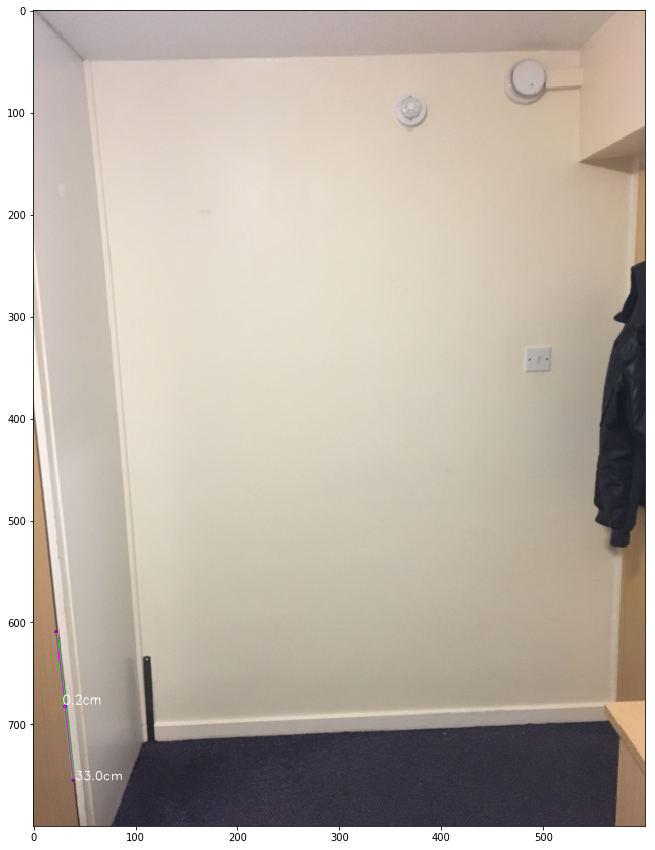

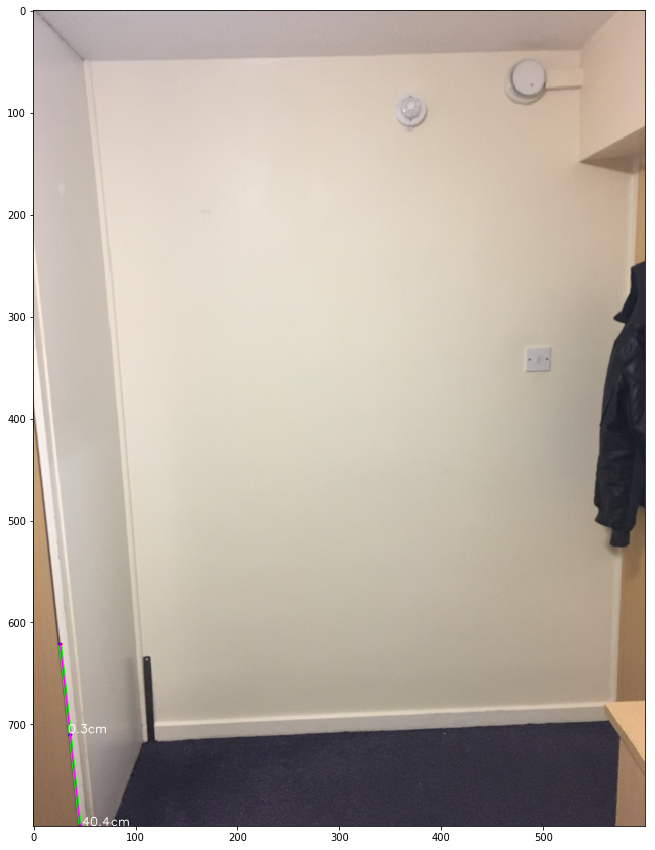

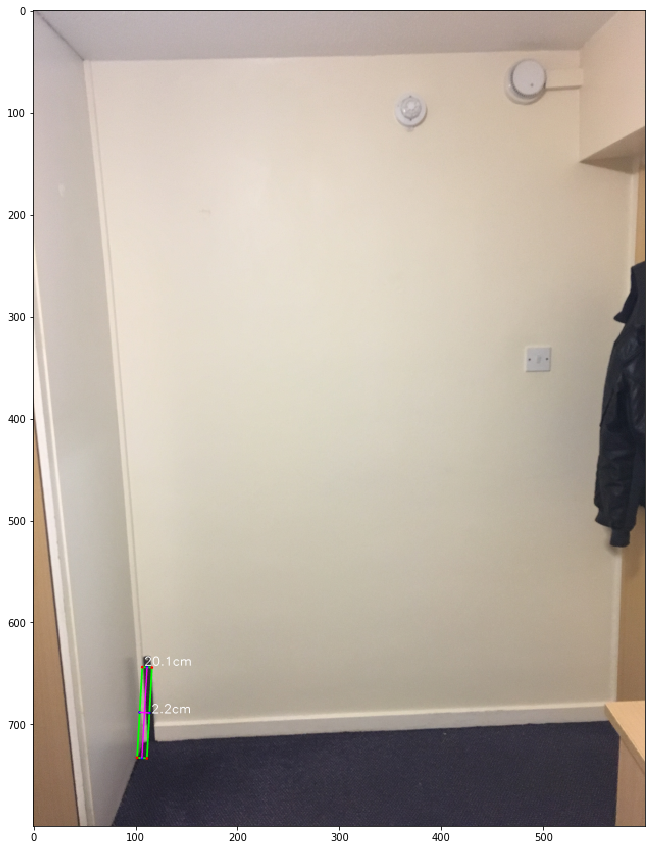

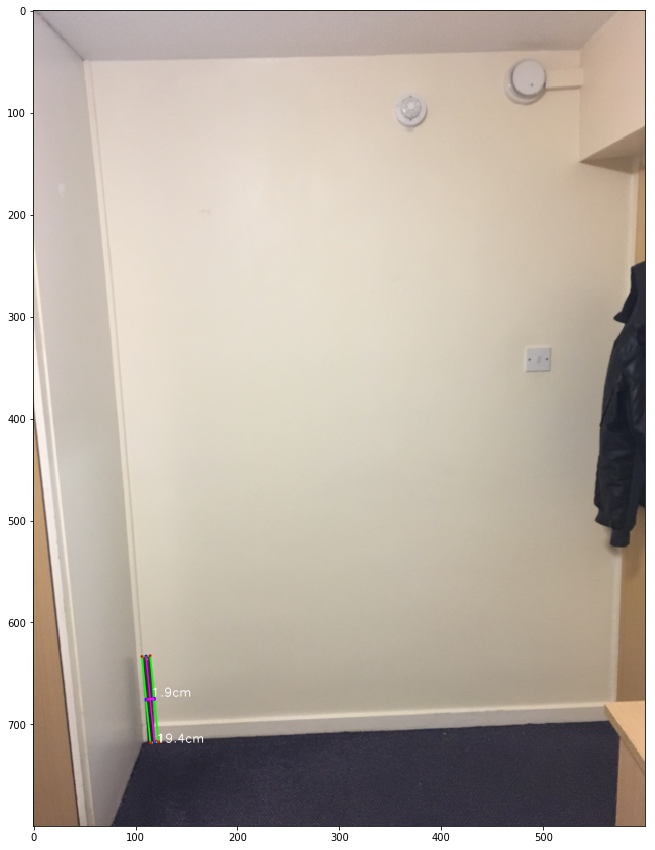

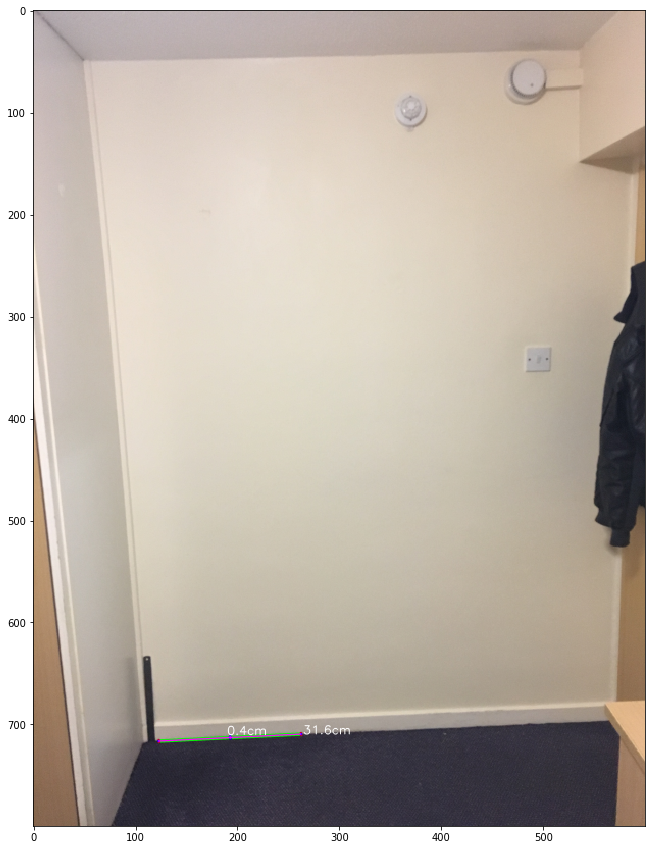

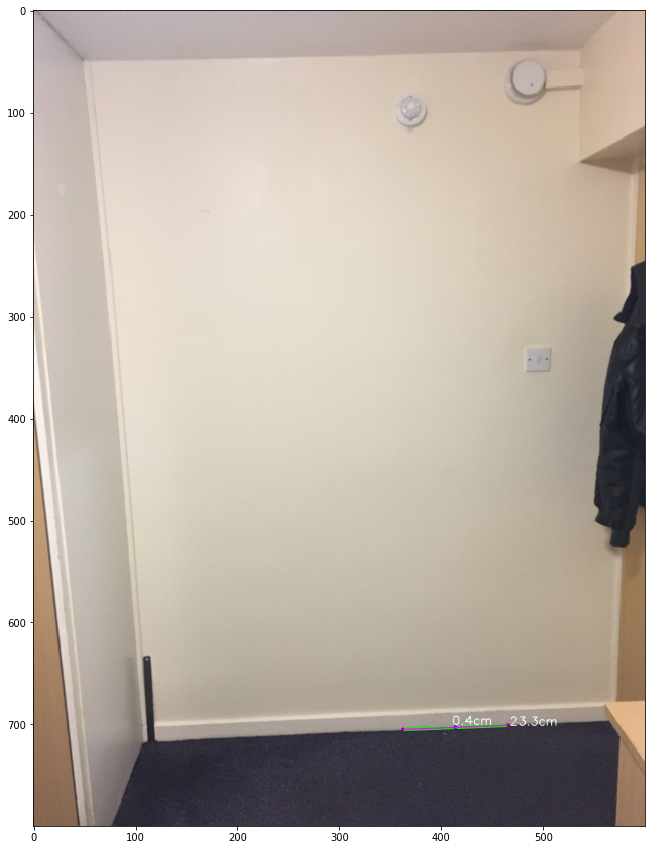

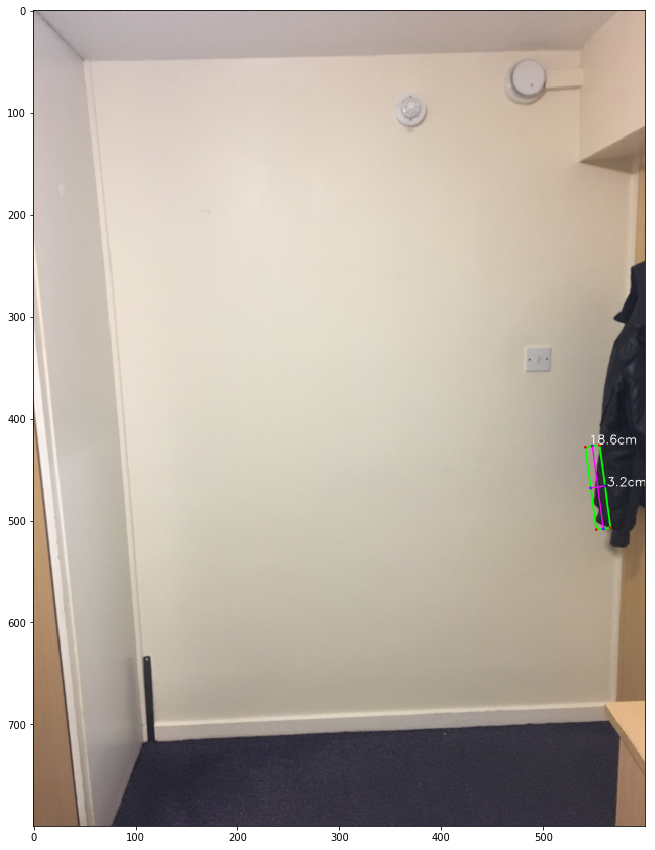

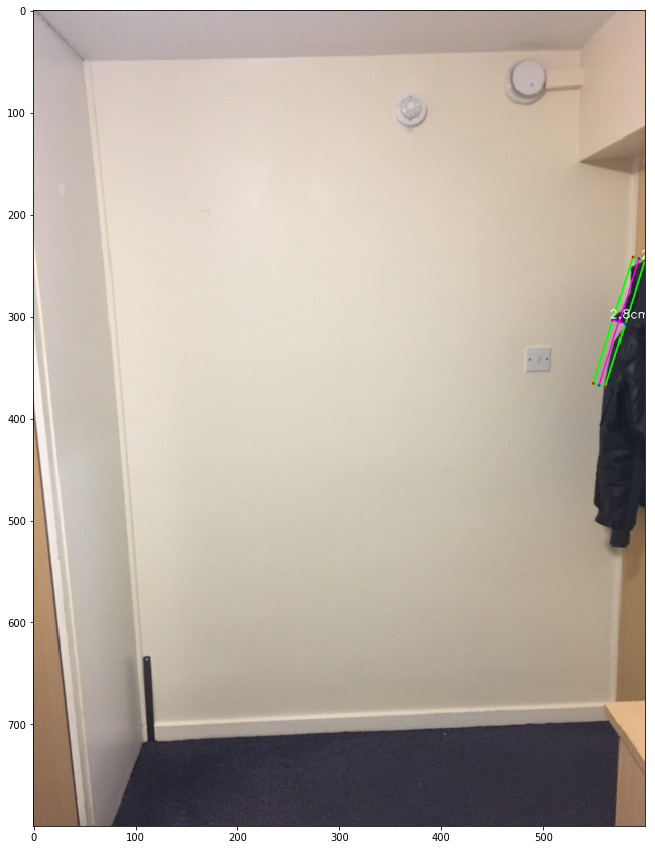

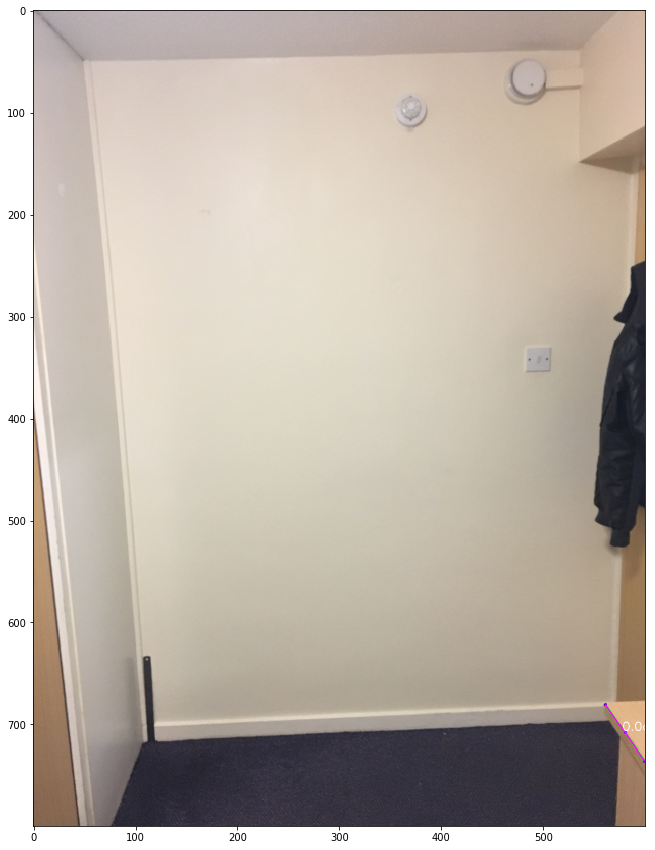

In [2]:
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import time


def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)


# Path to the image
impath = "images/Rule/6.jpg"
width = 33

# Load the image, convert it to grayscale, and blur it slightly
image = cv2.imread(impath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
 
# Perform edge detection, then perform a dilation + erosion to
# Close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
 
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
 
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
cnts = cnts[3:] # ************************** In the third position is the rule *******************
pixelsPerMetric = None

# loop over the contours individually
for c in cnts:
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 100:
        continue
 
    # compute the rotated bounding box of the contour
    orig = image.copy()
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
 
    # Order the points in the contour such that they appear, n top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding box
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 7)
    # Loop over the original points and draw them
    for (x, y) in box:
        cv2.circle(orig, (int(x), int(y)), 7, (0, 0, 255), -1)

    # Unpack the ordered bounding box, then compute the midpoint between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)
 
    # Compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)
 
    # Draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 7, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 7, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 7, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 7, (255, 0, 0), -1)
 
    # Draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)), (255, 0, 255), 5)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)), (255, 0, 255), 5)
    
    # compute the Euclidean distance between the midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
 
    # If the pixels per metric has not been initialized, then
    # compute it as the ratio of pixels to supplied metric (in this case, cm)
    if pixelsPerMetric is None:
        pixelsPerMetric = dB / width
    
    # compute the size of the object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric
 
    # Draw the object sizes on the image
    cv2.putText(orig, "{:.1f}cm".format(dimA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
                        2.0, (255, 255, 255), 4)
    cv2.putText(orig, "{:.1f}cm".format(dimB),(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
                        2.0, (255, 255, 255), 4)

    
    # ---------------------------------------------------------------------------------------------
    # Display image
    target = orig

    try:
        img_to_show = imutils.opencv2matplotlib(imutils.resize(target, width = 600))
    except:
        img_to_show = imutils.resize(target, width = 600)

    plt.rcParams['figure.figsize'] = (12,15)
    plt.imshow(img_to_show)
    plt.show()
    time.sleep(0.3)